In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

In [5]:
from sklearn.cluster import KMeans
from sklearn.model_selection  import train_test_split,GridSearchCV,StratifiedKFold,KFold
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

In [2]:
n=50
n_important=10
X,y=make_classification(n_samples=10000, n_features=n, n_informative=n_important, n_redundant=n-n_important, n_classes=2, random_state=0)
df=pd.DataFrame(X)
rename_cols={col:'col_'+str(col) for col in df.columns}
df.rename(columns=rename_cols,inplace=True)
df['y']=y

In [68]:
df.shape

(10000, 55)

### Test Leave-One-Out

In [71]:
# create random categories

l = df.shape[0]
nc = 20
nf = l // nc
for i in range(nf):
    df.loc[i*nf:(i+1)*nf,'cluster']=i

In [72]:
df.cluster.isna().sum()

0

In [73]:
df.groupby('cluster')['y'].agg(['mean','sum','count'])

,mean,sum,count
cluster,,,
0.0,0.516,258,500
1.0,0.504,252,500
2.0,0.494,247,500
3.0,0.488,244,500
4.0,0.490,245,500
5.0,0.514,257,500
6.0,0.504,252,500
7.0,0.448,224,500
8.0,0.534,267,500


In [74]:
df['s'] = df.groupby('cluster')['y'].transform('sum')
df['c'] = df.groupby('cluster')['y'].transform('count')
df['yt'] = (df['s']-df['y'])/(df['c']-1)

In [75]:
df.columns

Index(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'col_8', 'col_9', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14',
       'col_15', 'col_16', 'col_17', 'col_18', 'col_19', 'col_20', 'col_21',
       'col_22', 'col_23', 'col_24', 'col_25', 'col_26', 'col_27', 'col_28',
       'col_29', 'col_30', 'col_31', 'col_32', 'col_33', 'col_34', 'col_35',
       'col_36', 'col_37', 'col_38', 'col_39', 'col_40', 'col_41', 'col_42',
       'col_43', 'col_44', 'col_45', 'col_46', 'col_47', 'col_48', 'col_49',
       'y', 's', 'c', 'yt', 'cluster'],
      dtype='object')

In [76]:
X = df.drop(['y','s','c','cluster'],axis=1)
y= df['y'].copy()

In [89]:
rf=RandomForestClassifier(n_estimators=10,max_depth=15,random_state=70,n_jobs=-1,min_samples_leaf=10)
kf=KFold(n_splits=5,random_state=0,shuffle=True)

scores=[]
for train_id,val_id in kf.split(X):
    x_train,xval=X.iloc[train_id],X.iloc[val_id]
    y_train,yval=y.iloc[train_id],y.iloc[val_id]

    rf.fit(x_train,y_train)
    scores.append(rf.score(xval,yval))
scores=np.array(scores)
scores.mean()

0.9536

In [78]:
scores

array([0.9575, 0.9565, 0.9575, 0.961 , 0.944 ])

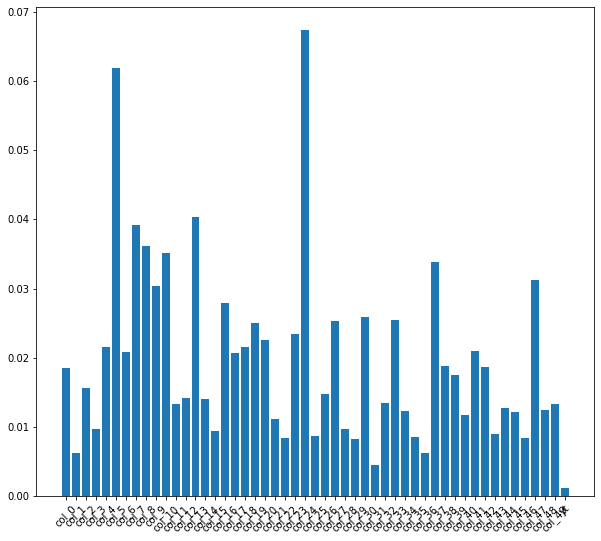

In [88]:
plt.figure(figsize=(10,9))
plt.bar(X.columns, rf.feature_importances_)
plt.xticks(rotation=45)
plt.show()

### The wrong way: target encode before spliting

In [7]:
df_train,df_test=train_test_split(df,test_size=0.2,random_state=20)
map_col=df_train.groupby('cluster')['y'].mean().to_dict()
df_train.loc[:,'cluster']=df_train['cluster'].map(map_col)

/Users/JoaoGomes/miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [9]:
X=df_train.drop('y',axis=1)
y=df_train['y']

In [10]:
rf=RandomForestClassifier(n_estimators=150,max_depth=20,random_state=70,n_jobs=-1,min_samples_leaf=10)
kf=KFold(n_splits=5,random_state=0,shuffle=True)

scores=[]
for train_id,val_id in kf.split(X):
    x_train,xval=X.iloc[train_id],X.iloc[val_id]
    y_train,yval=y.iloc[train_id],y.iloc[val_id]

    rf.fit(x_train,y_train)
    scores.append(rf.score(xval,yval))
scores=np.array(scores)
scores.mean()

0.9291666666666668

In [11]:
scores

array([0.95833333, 0.9375    , 0.94791667, 0.86458333, 0.9375    ])

In [12]:
df_test['cluster']=df_test['cluster'].map(map_col)
Xtest=df_test.drop('y',axis=1)
Ytest=df_test['y']

/var/folders/hc/ksky2t095_v6h164b5fdb3sc0000gn/T/ipykernel_28023/3231120719.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['cluster']=df_test['cluster'].map(map_col)


In [ ]:
rf.score(Xtest,Ytest)

In [ ]:
rf.feature_importances_

### The right way: first split then target encode

In [51]:
df.iloc[:10,-2]

0    0.011910
1    0.076923
2    0.766261
3    0.917720
4    0.741492
5    0.849674
6    0.263626
7    0.861700
8    0.346154
9    0.833740
Name: y, dtype: float64

In [58]:
kf=KFold(n_splits=10,random_state=0,shuffle=True)
df['yenc']=np.nan
df['cnt']=np.nan
for train_id,val_id in kf.split(df):
    xtrain,xval=df.iloc[train_id].copy(),df.iloc[val_id].copy()
    
    enc_y = xtrain.groupby('cluster')['y'].mean().to_dict()
    enc_cnt = xtrain.groupby('cluster')['y'].count().to_dict()
    df.iloc[val_id,-2] = df.iloc[val_id,-3].map(enc_y)
    df.iloc[val_id,-1] = df.iloc[val_id,-3].map(enc_cnt)

In [64]:
df.loc[df['cluster']==17,'yenc']

0      0.973684
24     0.973684
39     0.975000
59     1.000000
77     0.973684
80     0.974359
83     1.000000
103    0.973684
114    0.973684
133    0.973684
139    0.974359
149    0.973684
171    0.973684
200    0.975000
290    0.973684
320    0.975610
337    0.973684
350    0.973684
407    0.973684
410    0.974359
433    1.000000
434    0.973684
540    1.000000
552    0.973684
564    0.973684
578    0.973684
597    0.973684
601    0.973684
605    0.973684
649    1.000000
652    0.973684
712    1.000000
721    0.973684
723    0.975000
745    0.975000
758    0.973684
763    0.975000
779    0.975000
844    0.975610
891    0.973684
913    0.973684
923    0.973684
976    0.974359
Name: yenc, dtype: float64

In [29]:
kf=KFold(n_splits=5,random_state=0,shuffle=True)
rf=RandomForestClassifier(n_estimators=100,max_depth=20,random_state=0,n_jobs=-1,min_samples_leaf=10)

for train_id,val_id in kf.split(df):
    xtrain,xval=df.iloc[train_id].copy(),df.iloc[val_id].copy()
    ytrain,yval=xtrain.loc[:,'y'],xval.loc[:,'y']

    xtrain['t']=ytrain/10+0.5
    xval['t']=yval/10+0.5

    """ map_col=xtrain.groupby('cluster')['y'].mean().to_dict()
    xtrain['cluster']=xtrain['cluster'].map(map_col)
    map_col=xval.groupby('cluster')['y'].mean().to_dict()
    xval['cluster']=xval['cluster'].map(map_col)+0.4 """
    
    xtrain,xval=xtrain.drop('y',axis=1),xval.drop('y',axis=1)

    rf.fit(xtrain,ytrain)
    print(rf.score(xval,yval))

0.9583333333333334
0.9666666666666667
0.9583333333333334
0.9416666666666667
0.9


In [31]:
rf.feature_importances_.argmax()

501

In [32]:
len(xtrain.columns)

502

In [21]:
(xval['cluster'] -yval).value_counts()

 0.000000    111
 0.500000      3
-0.500000      3
-0.333333      2
 0.666667      1
dtype: int64

In [18]:
map_col

{1: 0.0,
 2: 1.0,
 4: 1.0,
 7: 0.0,
 11: 1.0,
 12: 0.0,
 13: 1.0,
 17: 0.0,
 18: 1.0,
 20: 1.0,
 21: 0.0,
 24: 0.0,
 26: 0.0,
 33: 0.0,
 35: 1.0,
 38: 0.0,
 43: 0.5,
 44: 1.0,
 46: 1.0,
 47: 0.0,
 49: 1.0,
 51: 1.0,
 53: 0.0,
 54: 0.0,
 55: 0.0,
 57: 0.0,
 62: 1.0,
 63: 0.0,
 65: 1.0,
 67: 0.0,
 70: 0.0,
 72: 0.0,
 74: 0.0,
 79: 0.0,
 81: 0.0,
 82: 1.0,
 83: 1.0,
 88: 1.0,
 91: 1.0,
 92: 1.0,
 94: 0.0,
 100: 0.0,
 102: 1.0,
 103: 0.0,
 107: 0.0,
 110: 0.0,
 113: 0.0,
 114: 0.0,
 116: 0.0,
 122: 0.0,
 125: 0.0,
 127: 1.0,
 128: 1.0,
 132: 1.0,
 133: 0.0,
 134: 0.0,
 143: 1.0,
 144: 1.0,
 147: 1.0,
 151: 0.0,
 152: 0.0,
 153: 0.6666666666666666,
 154: 1.0,
 159: 0.0,
 163: 0.0,
 167: 1.0,
 170: 0.0,
 174: 1.0,
 186: 0.0,
 189: 0.0,
 191: 1.0,
 195: 1.0,
 196: 1.0,
 198: 0.0,
 199: 0.0,
 208: 1.0,
 214: 0.0,
 217: 1.0,
 220: 1.0,
 225: 1.0,
 227: 1.0,
 228: 0.5,
 232: 1.0,
 233: 1.0,
 235: 0.0,
 237: 1.0,
 239: 0.0,
 240: 0.0,
 242: 1.0,
 244: 0.0,
 246: 1.0,
 251: 0.0,
 255: 1.0,
 257: 1

In [9]:
rf.feature_importances_

array([0.058017  , 0.05197257, 0.02116001, 0.01423254, 0.02679718,
       0.01227533, 0.03368493, 0.00607589, 0.00238761, 0.00801643,
       0.00181852, 0.04417946, 0.00906545, 0.00710951, 0.0656683 ,
       0.00409355, 0.02129129, 0.00814754, 0.09315664, 0.00304109,
       0.50780915])

In [76]:
kf=KFold(n_splits=10,random_state=0,shuffle=True)
rf=RandomForestClassifier(n_estimators=100,max_depth=6,random_state=0,n_jobs=-1)

for train_id,val_id in kf.split(df):
    xtrain,xval=df.iloc[train_id].copy(),df.iloc[val_id].copy()

    map_col=xtrain.groupby('col_20')['y'].mean().to_dict()
    xtrain['col_20']=xtrain['col_20'].map(map_col)
    xval['col_20']=xval['col_20'].map(map_col)
    ytrain,yval=xtrain.loc[:,'y'],xval.loc[:,'y']
    xtrain,xval=xtrain.iloc[:,:-1],xval.iloc[:,:-1]

    rf.fit(xtrain,ytrain)
    print(rf.score(xval,yval))

0.9235
0.925
0.9206
0.9219
0.9276
0.9268
0.9228
0.9242
0.9207
0.9218


In [73]:
xtrain.col_20.unique()

array([0.86070165, 0.18921643, 0.67510937, 0.89111253, 0.15115025,
       0.02135765, 0.8048486 , 0.10600352, 0.03658537, 0.98106236])

In [50]:
rf=RandomForestClassifier(n_estimators=100,max_depth=20,random_state=0)

In [51]:
rf.fit(xtrain,ytrain)

RandomForestClassifier(max_depth=20, random_state=0)

In [53]:
rf.score(xtest,ytest),rf.score(xtrain,ytrain)

(0.9617, 0.9934375)

## RFECV

In [79]:
from sklearn.feature_selection import RFECV

In [82]:
X=df.drop('y',axis=1)
y=df['y']

In [83]:
rfe=RFECV(estimator=rf,cv=5,scoring='accuracy')
rfe.fit(X,y)

RFECV(cv=5,
      estimator=RandomForestClassifier(max_depth=20, min_samples_leaf=10,
                                       n_jobs=-1, random_state=0),
      scoring='accuracy')

In [89]:
X_transformed = rfe.transform(X)

In [92]:
X_transformed

array([[ -4.60986106,  -4.99112217,   2.87487539, ...,   1.28606805,
         -8.25057439,   0.69973963],
       [ -1.64376471,  -1.11287986,   1.54645669, ...,   2.84063189,
          1.89108362,  -0.8285572 ],
       [ -1.04336582,   1.4244628 ,  -2.96323135, ...,  -3.34389493,
         -2.85111595,  -0.78496269],
       ...,
       [ -0.11275432,  -2.43382332,  -2.10411208, ...,  -4.91974894,
          1.16214469,   2.81247204],
       [ -4.21653541,  -2.3341965 ,  -2.45475625, ...,  -4.61342604,
         -4.70474029,   3.50355184],
       [-10.04963747,   5.648913  ,  -0.75871803, ...,  -3.2046927 ,
         -5.46153899,   1.84151251]])

## Feature Importance

In [122]:
from eli5 import show_weights, show_prediction, explain_prediction
from eli5.formatters import format_as_text

In [80]:
rf.feature_importances_

array([0.0906415 , 0.05884074, 0.02685866, 0.02052799, 0.02598829,
       0.01227632, 0.04605283, 0.01435457, 0.00903182, 0.02182733,
       0.00645207, 0.04398979, 0.03613963, 0.02715003, 0.10551366,
       0.0195239 , 0.04028528, 0.01522972, 0.10386326, 0.00778623,
       0.26766637])

In [79]:
show_weights(rf,feature_names=xtrain.columns.to_list())

Weight,Feature
0.2677 ± 0.4988,col_20
0.1055 ± 0.3098,col_14
0.1039 ± 0.3435,col_18
0.0906 ± 0.2547,col_0
0.0588 ± 0.1867,col_1
0.0461 ± 0.0759,col_6
0.0440 ± 0.2028,col_11
0.0403 ± 0.0682,col_16
0.0361 ± 0.0413,col_12
0.0272 ± 0.0727,col_13


In [134]:
pred=explain_prediction(rf, xtest.iloc[5,:], feature_names=xtrain.columns.to_list(),top=(4,3))

In [135]:
print(format_as_text(pred))

Explained as: decision path

Features with largest coefficients.

Feature weights are calculated by following decision paths in trees
of an ensemble (or a single tree for DecisionTreeClassifier).
Each node of the tree has an output score, and contribution of a feature
on the decision path is how much the score changes from parent to child.
Weights of all features sum to the output score or proba of the estimator.

Caveats:
1. Feature weights just show if the feature contributed positively or
   negatively to the final score, and does not show how increasing or
   decreasing the feature value will change the prediction.
2. In some cases, feature weight can be close to zero for an important feature.
   For example, in a single tree that computes XOR function, the feature at the
   top of the tree will have zero weight because expected scores for both
   branches are equal, so decision at the top feature does not change the
   expected score. For an ensemble predicting XOR functions it mi

In [133]:
rf.predict_proba(xtest)[:6]

array([[0.5875753 , 0.4124247 ],
       [0.94080996, 0.05919004],
       [0.94168722, 0.05831278],
       [0.91478625, 0.08521375],
       [0.97470156, 0.02529844],
       [0.57834607, 0.42165393]])